<a href="https://colab.research.google.com/github/2ndeyBlaq/Building_Energy_Forcast/blob/main/Energy_consumption_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


C:\Users\adela\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
working_dir = os.getcwd()
os.chdir(working_dir)
working_dir

# Data Cleaning & Preparation

In [ ]:
# Import energy consumption dataset

consumption = pd.read_csv('building_consumption.csv')
consumption

,campus_id,meter_id,timestamp,consumption
0,1,1,2019-03-29 01:15:00,0.01100
1,1,1,2019-03-29 01:30:00,0.02100
2,1,1,2019-03-29 01:45:00,0.03800
3,1,1,2019-03-29 02:00:00,0.87100
4,1,1,2019-03-29 02:15:00,0.87300
...,...,...,...,...
8095519,1,64,2022-04-30 22:45:00,0.84375
8095520,1,64,2022-04-30 23:00:00,1.15625
8095521,1,64,2022-04-30 23:15:00,1.32813
8095522,1,64,2022-04-30 23:30:00,1.21875


In [ ]:
# energy consumption features data type

consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8095524 entries, 0 to 8095523
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   campus_id    int64  
 1   meter_id     int64  
 2   timestamp    object 
 3   consumption  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 247.1+ MB


In [ ]:
# unique campus_id and meter_id

print('Unique campus_id: ', consumption['campus_id'].unique())
print('Unique meter_id: ', consumption['meter_id'].unique())

Unique campus_id:  [1 2 3]
Unique meter_id:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


In [ ]:
# count of records per meter_id for campus_id 1

consumption_grouped = consumption[(consumption['campus_id'] == 1)]

consumption_grouped = consumption_grouped.groupby(['meter_id']).count().sort_values(by=['consumption'], ascending=False)
consumption_grouped.head()

,campus_id,timestamp,consumption
meter_id,,,
4,148288,148288,148288
25,148203,148203,148203
23,148127,148127,148127
33,148050,148050,148050
26,147978,147978,147978


- Meter_id 4 from campus_id 1 has the highest number of records and will be used for analysis

In [ ]:
# Extract campus_id 1 and meter_id 4 for analysis

df_consumption = consumption[(consumption['campus_id'] == 1) & (consumption['meter_id'] ==4) ]
df_consumption

,campus_id,meter_id,timestamp,consumption
122254,1,4,2018-01-01 00:15:00,3.600
122255,1,4,2018-01-01 00:30:00,3.846
122256,1,4,2018-01-01 00:45:00,4.099
122257,1,4,2018-01-01 01:00:00,3.951
122258,1,4,2018-01-01 01:15:00,3.958
...,...,...,...,...
270537,1,4,2022-04-30 22:45:00,5.293
270538,1,4,2022-04-30 23:00:00,5.479
270539,1,4,2022-04-30 23:15:00,6.598
270540,1,4,2022-04-30 23:30:00,5.753


In [ ]:
# Drop unused columns 'campus_id','meter_id'

df_consumption = df_consumption.drop(['campus_id','meter_id'], axis=1)
df_consumption

,timestamp,consumption
122254,2018-01-01 00:15:00,3.600
122255,2018-01-01 00:30:00,3.846
122256,2018-01-01 00:45:00,4.099
122257,2018-01-01 01:00:00,3.951
122258,2018-01-01 01:15:00,3.958
...,...,...
270537,2022-04-30 22:45:00,5.293
270538,2022-04-30 23:00:00,5.479
270539,2022-04-30 23:15:00,6.598
270540,2022-04-30 23:30:00,5.753


In [ ]:
# Change timestamp data type to datetime

df_consumption['timestamp']= pd.to_datetime(df_consumption['timestamp'])

In [ ]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148288 entries, 122254 to 270541
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    148288 non-null  datetime64[ns]
 1   consumption  148288 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 MB


In [ ]:
# Description of energy consumption central tendencies

df_consumption.describe()

,consumption
count,148288.000000
mean,6.316275
std,4.403881
min,-2.825000
25%,3.204000
50%,5.210000
75%,7.637000
max,22.318000


<AxesSubplot:xlabel='consumption', ylabel='Density'>

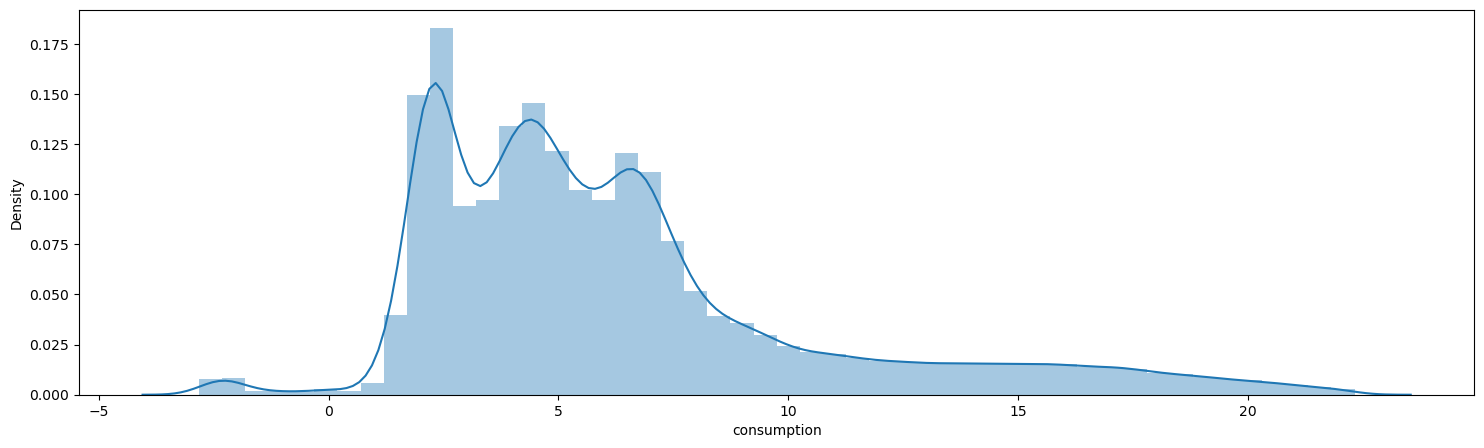

In [ ]:
# Visualize energy consumption ditribution

sns.distplot(df_consumption['consumption'])

- The dataset has a multi-modal distribution and as such consists of more than one group of data

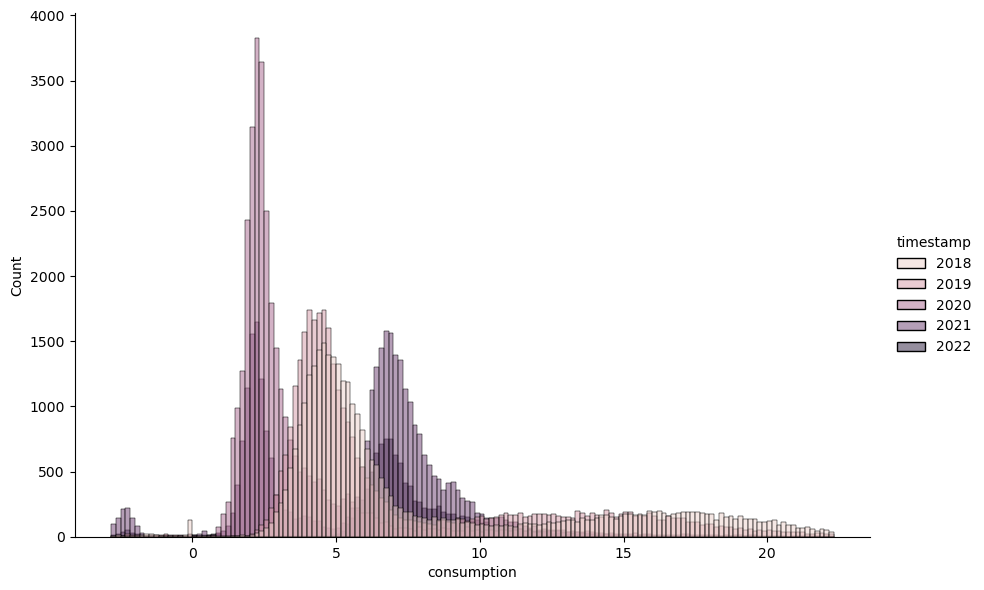

In [ ]:
# View group of data

sns.displot(df_consumption, x="consumption", hue=pd.to_datetime(df_consumption['timestamp']).dt.year, height=6, aspect=1.5)

- Years 2020 - 2022 have varied measure of central tendencies. This may be impacted by COVID-19 prevalance with those years. Analysis will therefore be based on pre COVID-19

<AxesSubplot:xlabel='timestamp'>

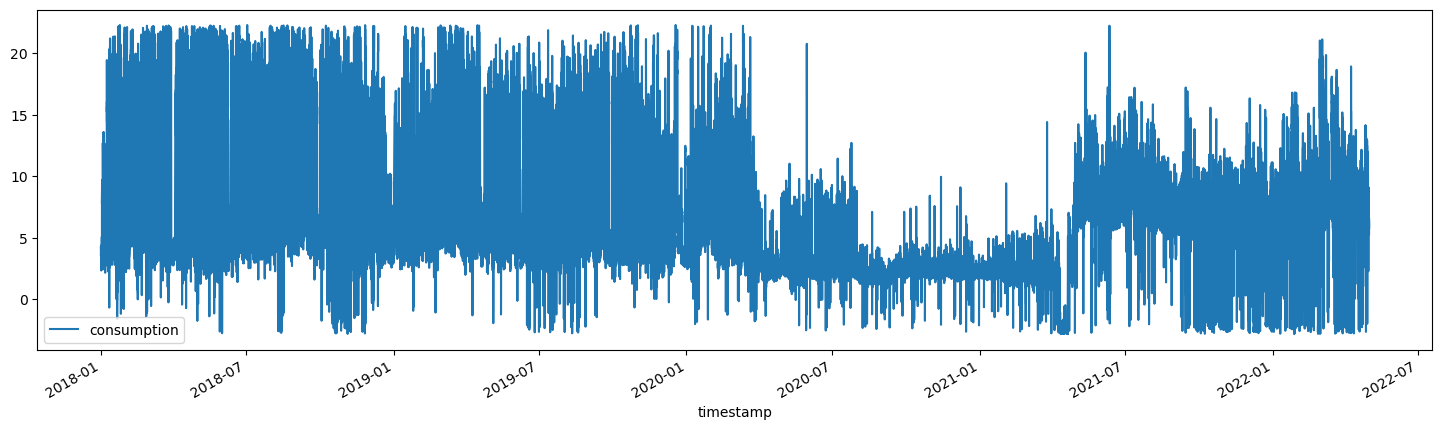

In [ ]:
# Visualize energy consumption with time

df_consumption.plot(x='timestamp', y='consumption')

In [ ]:
# Import weather dataset

df_weather = pd.read_csv('weather_data.csv')
df_weather

,campus_id,timestamp,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
0,1,2018-01-01 00:00:00,16.6,16.2,13.5,84.0,3.6,142.0
1,1,2018-01-01 00:01:00,17.2,16.1,13.6,85.0,0.0,134.0
2,1,2018-01-01 00:02:00,16.9,16.1,13.6,85.0,1.8,130.0
3,1,2018-01-01 00:03:00,16.9,16.1,13.6,85.0,1.8,130.0
4,1,2018-01-01 00:04:00,16.0,16.0,13.5,85.0,5.4,129.0
...,...,...,...,...,...,...,...,...
7396515,5,2022-04-30 21:30:00,7.5,9.7,7.8,88.0,NaN,NaN
7396516,5,2022-04-30 22:00:00,7.4,9.3,7.7,90.0,NaN,NaN
7396517,5,2022-04-30 22:30:00,7.5,9.4,7.7,89.0,NaN,NaN
7396518,5,2022-04-30 23:00:00,7.7,9.2,8.3,94.0,NaN,NaN


In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7396520 entries, 0 to 7396519
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   campus_id              int64  
 1   timestamp              object 
 2   apparent_temperature   float64
 3   air_temperature        float64
 4   dew_point_temperature  float64
 5   relative_humidity      float64
 6   wind_speed             float64
 7   wind_direction         float64
dtypes: float64(6), int64(1), object(1)
memory usage: 451.4+ MB


In [ ]:
# Change timestamp data type to datetime

df_weather['timestamp']= pd.to_datetime(df_weather['timestamp'])

In [ ]:
# Extract campus_id 1 from weather dataset

df_weather = df_weather[(df_weather['campus_id'] == 1)]
df_weather

,campus_id,timestamp,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
0,1,2018-01-01 00:00:00,16.6,16.2,13.5,84.0,3.6,142.0
1,1,2018-01-01 00:01:00,17.2,16.1,13.6,85.0,0.0,134.0
2,1,2018-01-01 00:02:00,16.9,16.1,13.6,85.0,1.8,130.0
3,1,2018-01-01 00:03:00,16.9,16.1,13.6,85.0,1.8,130.0
4,1,2018-01-01 00:04:00,16.0,16.0,13.5,85.0,5.4,129.0
...,...,...,...,...,...,...,...,...
1836297,1,2022-04-30 21:30:00,10.9,13.2,7.6,69.0,NaN,NaN
1836298,1,2022-04-30 22:00:00,11.3,14.0,7.5,65.0,NaN,NaN
1836299,1,2022-04-30 22:30:00,11.4,14.1,7.2,63.0,NaN,NaN
1836300,1,2022-04-30 23:00:00,10.7,13.8,7.1,64.0,NaN,NaN


In [ ]:
# drop campus_id column

df_weather = df_weather.drop(['campus_id'], axis=1)
df_weather

,timestamp,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
0,2018-01-01 00:00:00,16.6,16.2,13.5,84.0,3.6,142.0
1,2018-01-01 00:01:00,17.2,16.1,13.6,85.0,0.0,134.0
2,2018-01-01 00:02:00,16.9,16.1,13.6,85.0,1.8,130.0
3,2018-01-01 00:03:00,16.9,16.1,13.6,85.0,1.8,130.0
4,2018-01-01 00:04:00,16.0,16.0,13.5,85.0,5.4,129.0
...,...,...,...,...,...,...,...
1836297,2022-04-30 21:30:00,10.9,13.2,7.6,69.0,NaN,NaN
1836298,2022-04-30 22:00:00,11.3,14.0,7.5,65.0,NaN,NaN
1836299,2022-04-30 22:30:00,11.4,14.1,7.2,63.0,NaN,NaN
1836300,2022-04-30 23:00:00,10.7,13.8,7.1,64.0,NaN,NaN


In [ ]:
# describe weather features measure of central tendencies

df_weather.describe()

,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
count,1.836302e+06,1.836302e+06,1.836302e+06,1.836302e+06,1.820966e+06,1.820247e+06
mean,1.323675e+01,1.512402e+01,9.327866e+00,7.273230e+01,9.954108e+00,1.885878e+02
std,6.700631e+00,6.333154e+00,4.001557e+00,2.205645e+01,7.281217e+00,1.014612e+02
min,-7.000000e+00,-2.600000e+00,-6.800000e+00,7.000000e+00,0.000000e+00,0.000000e+00
25%,8.400000e+00,1.080000e+01,6.400000e+00,5.600000e+01,5.400000e+00,9.400000e+01
50%,1.230000e+01,1.420000e+01,9.000000e+00,7.300000e+01,9.400000e+00,2.060000e+02
75%,1.730000e+01,1.860000e+01,1.190000e+01,9.500000e+01,1.480000e+01,2.630000e+02
max,4.320000e+01,4.470000e+01,2.400000e+01,1.000000e+02,7.600000e+01,3.590000e+02


<AxesSubplot:xlabel='timestamp'>

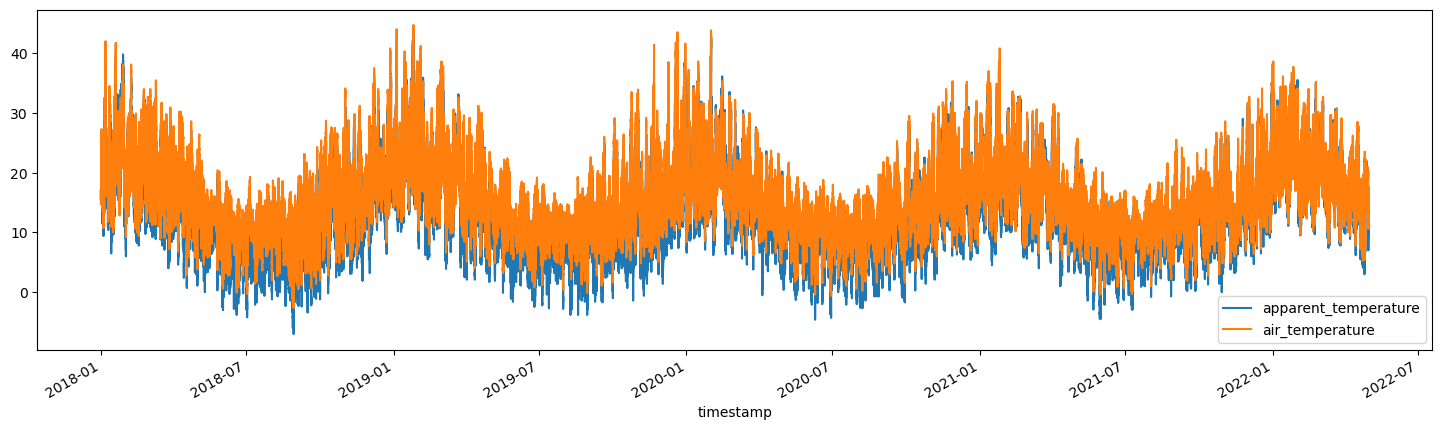

In [ ]:
# Visualize temperature over time

df_weather.plot(x='timestamp', y=(['apparent_temperature','air_temperature']))

- Temperature peaks around December - January with minimum recordings during the middle of the year

In [ ]:
# Harmonize weather dataset together with energy consumption dataset using timestamp

df_merged = pd.merge(df_consumption, df_weather, how='left', on=['timestamp'])
df_merged

,timestamp,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
0,2018-01-01 00:15:00,3.600,16.0,15.9,13.6,86.0,5.4,134.0
1,2018-01-01 00:30:00,3.846,16.0,15.9,13.7,87.0,5.4,115.0
2,2018-01-01 00:45:00,4.099,16.2,15.8,13.6,87.0,3.6,120.0
3,2018-01-01 01:00:00,3.951,16.7,15.6,13.4,87.0,0.0,120.0
4,2018-01-01 01:15:00,3.958,16.4,15.4,13.2,87.0,0.0,120.0
...,...,...,...,...,...,...,...,...
148283,2022-04-30 22:45:00,5.293,NaN,NaN,NaN,NaN,NaN,NaN
148284,2022-04-30 23:00:00,5.479,10.7,13.8,7.1,64.0,NaN,NaN
148285,2022-04-30 23:15:00,6.598,NaN,NaN,NaN,NaN,NaN,NaN
148286,2022-04-30 23:30:00,5.753,11.2,13.5,7.3,66.0,NaN,NaN


In [ ]:
# Extract records of the years 2018 -2919 for analysis

df = df_merged[df_merged['timestamp'].dt.year.between(2018,2019, inclusive=True)]
# df = df_merged[df_merged['timestamp'].dt.year==2019]
df

,timestamp,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
0,2018-01-01 00:15:00,3.600,16.0,15.9,13.6,86.0,5.4,134.0
1,2018-01-01 00:30:00,3.846,16.0,15.9,13.7,87.0,5.4,115.0
2,2018-01-01 00:45:00,4.099,16.2,15.8,13.6,87.0,3.6,120.0
3,2018-01-01 01:00:00,3.951,16.7,15.6,13.4,87.0,0.0,120.0
4,2018-01-01 01:15:00,3.958,16.4,15.4,13.2,87.0,0.0,120.0
...,...,...,...,...,...,...,...,...
69112,2019-12-31 22:45:00,3.646,14.3,15.0,8.5,65.0,1.8,179.0
69113,2019-12-31 23:00:00,3.348,13.4,14.8,8.7,67.0,1.8,177.0
69114,2019-12-31 23:15:00,3.160,13.5,14.8,9.0,68.0,5.4,149.0
69115,2019-12-31 23:30:00,3.343,13.4,14.4,8.8,69.0,0.0,165.0


# Descriptive Analysis

### Measure of central tendencies

In [ ]:
# Measure of central tendencies

df.describe()

,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction
count,69117.000000,68729.000000,68729.000000,68729.000000,68729.000000,68729.000000,68729.000000
mean,7.757543,13.124162,15.213664,8.829078,70.290227,10.062188,183.186413
std,5.038781,6.867294,6.496655,4.074182,22.187731,7.040350,104.814136
min,-2.807000,-6.600000,-2.400000,-5.300000,7.000000,0.000000,0.000000
25%,4.322000,8.000000,10.700000,5.900000,54.000000,5.400000,76.000000
50%,5.358000,12.100000,14.200000,8.400000,71.000000,9.400000,204.000000
75%,10.705000,17.500000,18.900000,11.400000,90.000000,14.800000,263.000000
max,22.318000,42.400000,44.400000,23.600000,100.000000,51.800000,359.000000


<AxesSubplot:xlabel='consumption', ylabel='Density'>

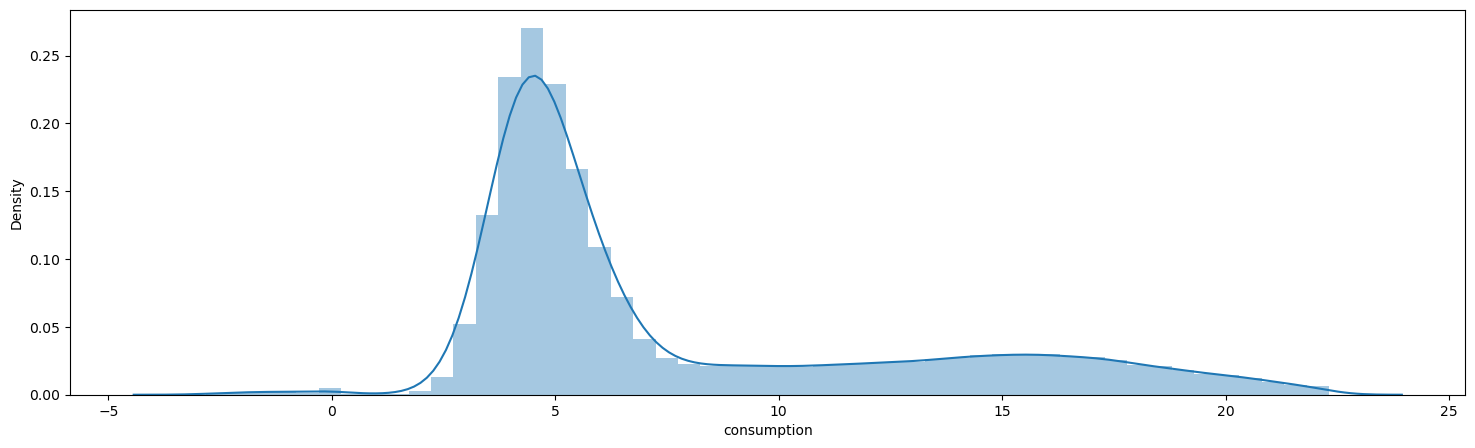

In [ ]:
# Distribution of energy consumption

sns.distplot(df['consumption'])

In [ ]:
print ('Kurtosis: ', df['consumption'].kurt())

Kurtosis:  0.11255128813239601


- The skewness is almost symmetrical

In [ ]:
# Generate and append time features to dataset

df['year'] = pd.to_datetime(df['timestamp']).dt.year
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df['month_of_Year'] = pd.to_datetime(df['timestamp']).dt.month_name()
df['day'] = pd.to_datetime(df['timestamp']).dt.day
df['day_of_Week'] = pd.to_datetime(df['timestamp']).dt.day_name()
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df["is_weekend"] = pd.to_datetime(df['timestamp']).dt.day_name().isin(['Saturday', 'Sunday'])
df["is_weekend"] = df["is_weekend"].astype(int)

df

,timestamp,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction,year,month,month_of_Year,day,day_of_Week,hour,is_weekend
0,2018-01-01 00:15:00,3.600,16.0,15.9,13.6,86.0,5.4,134.0,2018,1,January,1,Monday,0,0
1,2018-01-01 00:30:00,3.846,16.0,15.9,13.7,87.0,5.4,115.0,2018,1,January,1,Monday,0,0
2,2018-01-01 00:45:00,4.099,16.2,15.8,13.6,87.0,3.6,120.0,2018,1,January,1,Monday,0,0
3,2018-01-01 01:00:00,3.951,16.7,15.6,13.4,87.0,0.0,120.0,2018,1,January,1,Monday,1,0
4,2018-01-01 01:15:00,3.958,16.4,15.4,13.2,87.0,0.0,120.0,2018,1,January,1,Monday,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69112,2019-12-31 22:45:00,3.646,14.3,15.0,8.5,65.0,1.8,179.0,2019,12,December,31,Tuesday,22,0
69113,2019-12-31 23:00:00,3.348,13.4,14.8,8.7,67.0,1.8,177.0,2019,12,December,31,Tuesday,23,0
69114,2019-12-31 23:15:00,3.160,13.5,14.8,9.0,68.0,5.4,149.0,2019,12,December,31,Tuesday,23,0
69115,2019-12-31 23:30:00,3.343,13.4,14.4,8.8,69.0,0.0,165.0,2019,12,December,31,Tuesday,23,0


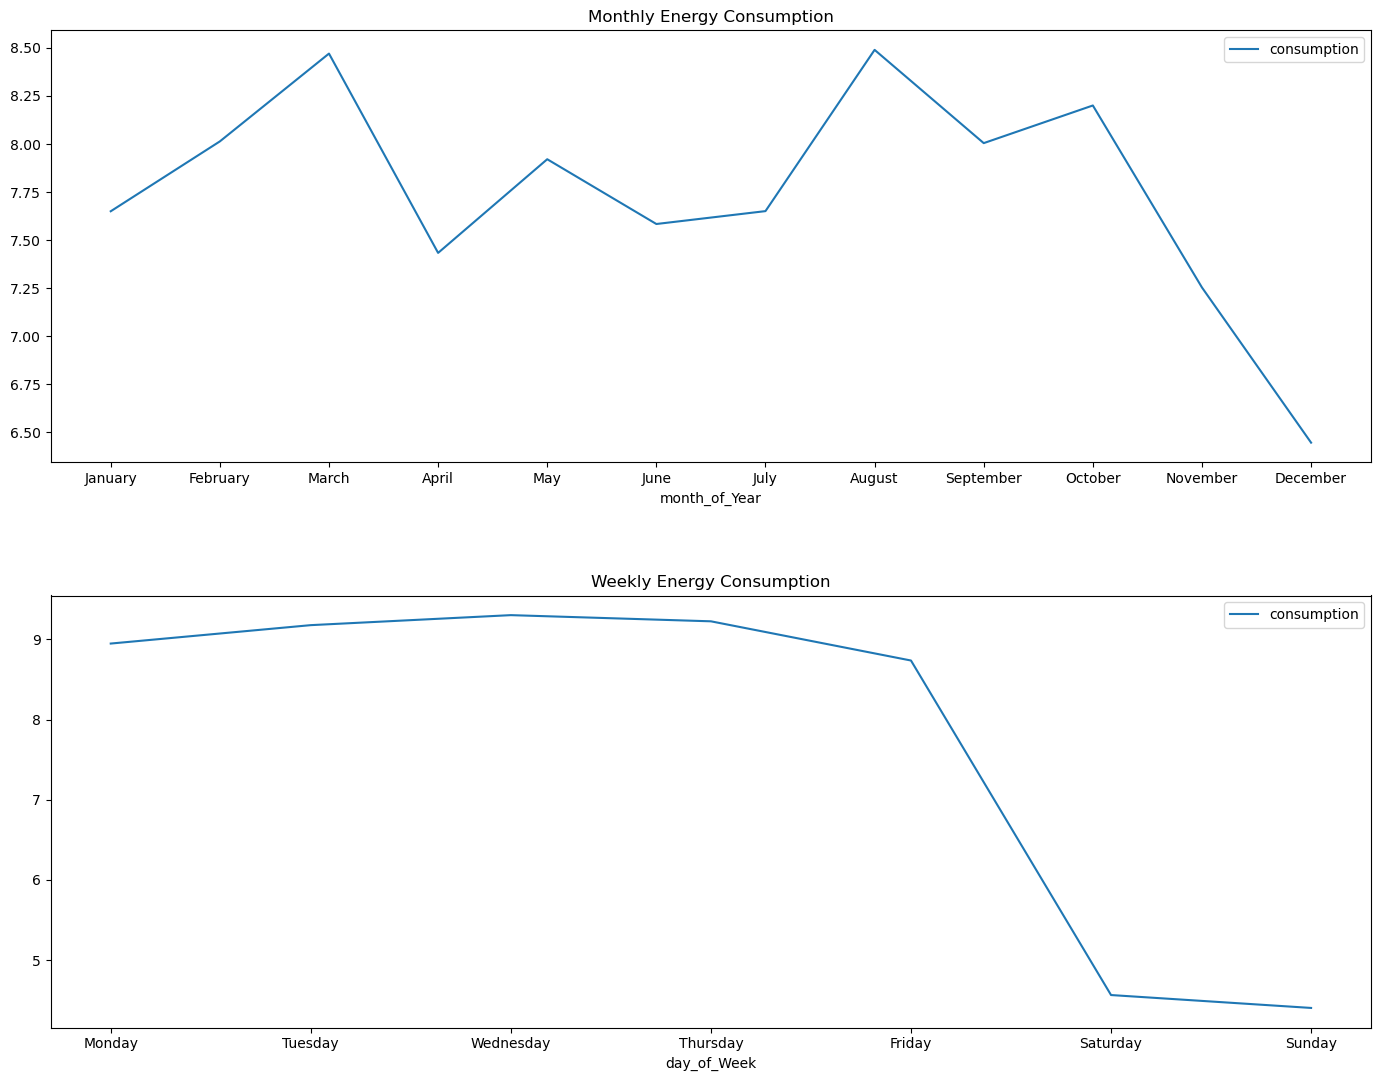

In [ ]:
# Plot consumption and temperature simultaneously because they are relatively on the same scale

fig, ax = plt.subplots(2, 1, figsize=(15, 12))

ax1 = sns.lineplot(x=df['month_of_Year'], y=df['consumption'], label='consumption', ci=None, ax=ax[0])

ax2 = sns.lineplot(x=df['day_of_Week'], y=df['consumption'], label='consumption', ci=None, ax=ax[1])


ax1.set(ylabel='', title='Monthly Energy Consumption')
ax2.set(ylabel='', title='Weekly Energy Consumption')

fig.tight_layout(pad=5.0)
plt.show()

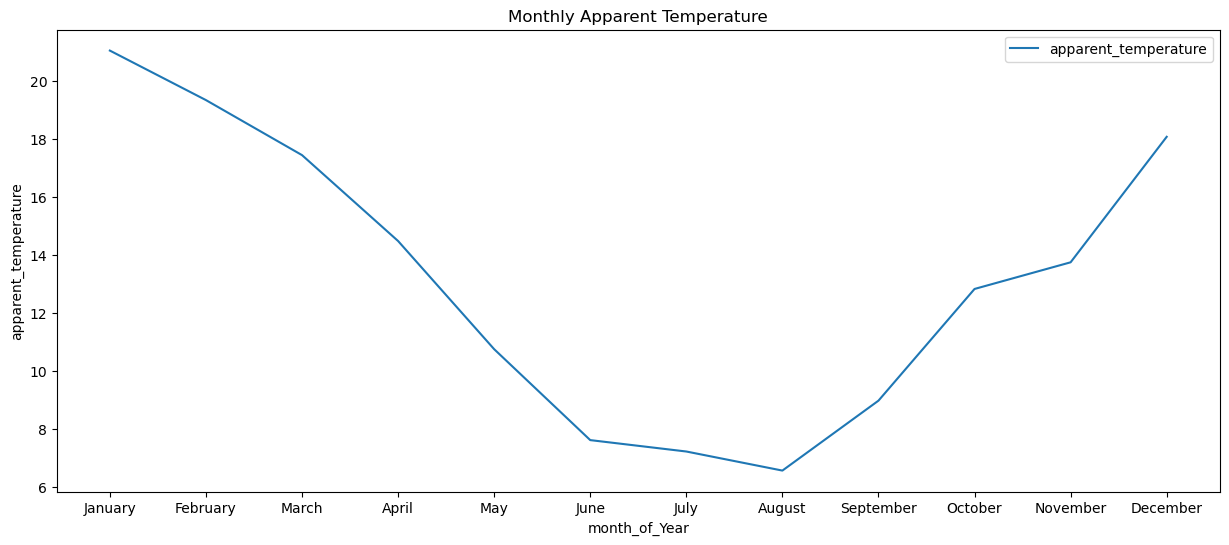

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df['month_of_Year'], y=df['apparent_temperature'], label='apparent_temperature', ci=None)
plt.title("Monthly Apparent Temperature")
plt.show()

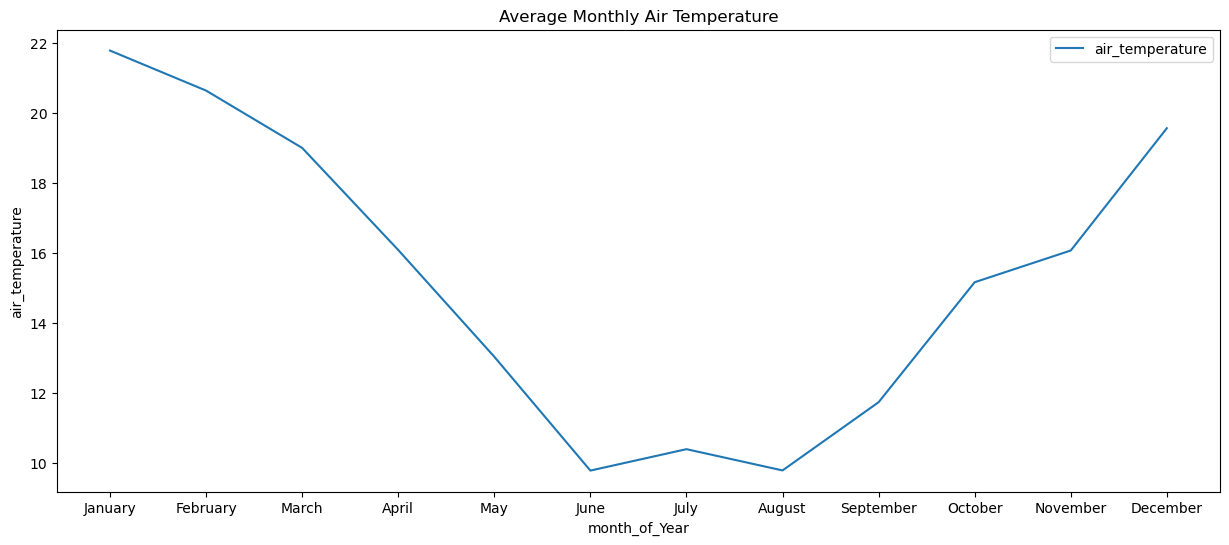

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df['month_of_Year'], y=df['air_temperature'], label='air_temperature', ci=None)
plt.title("Average Monthly Air Temperature")
plt.show()

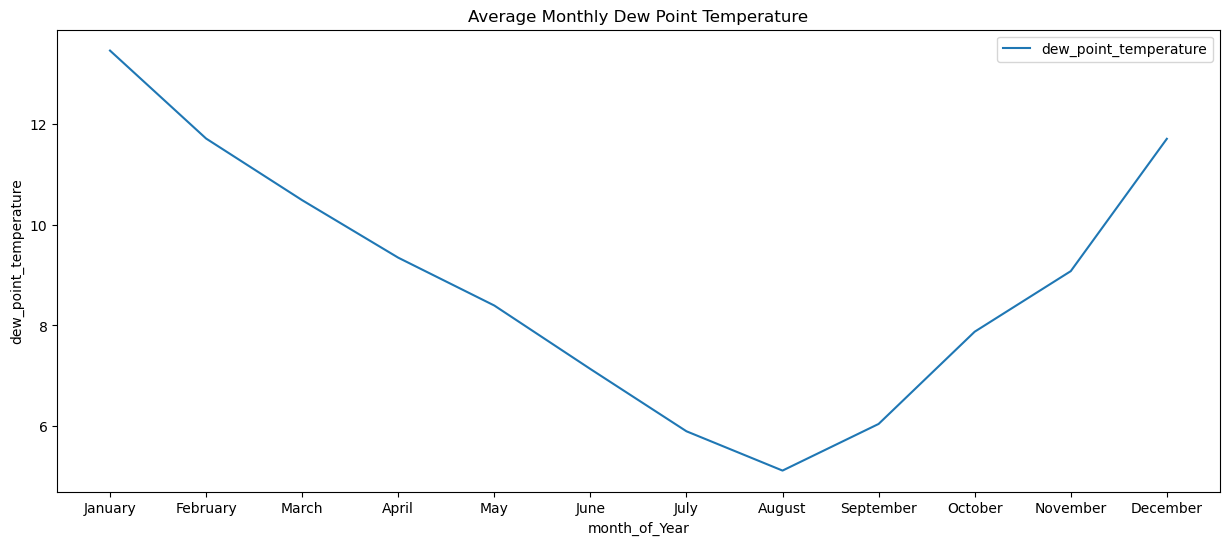

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df['month_of_Year'], y=df['dew_point_temperature'], label='dew_point_temperature', ci=None)
plt.title("Average Monthly Dew Point Temperature")
plt.show()

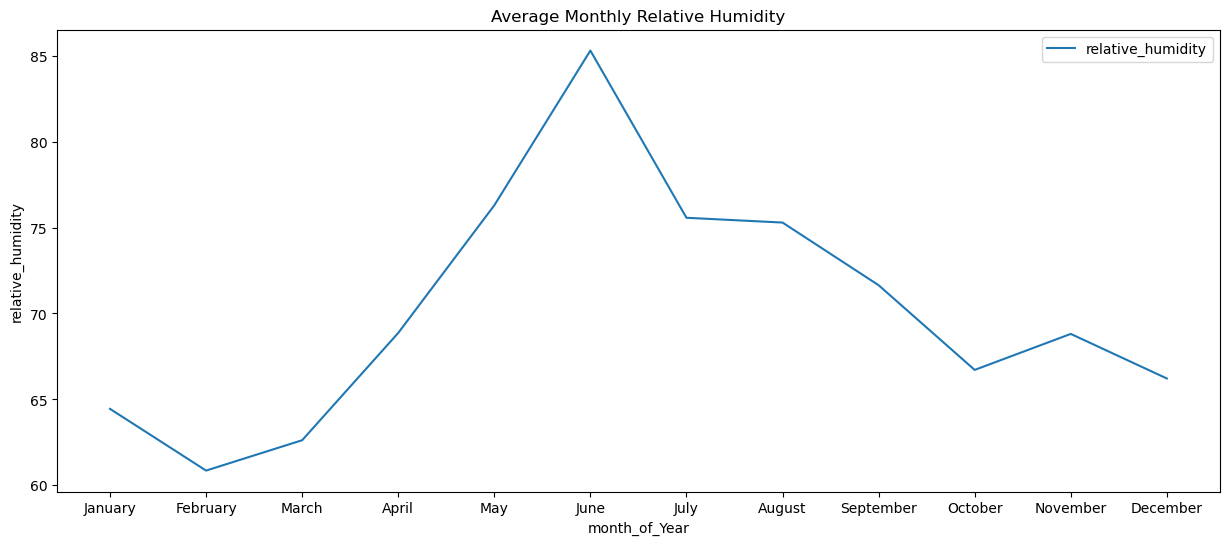

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df['month_of_Year'], y=df['relative_humidity'], label='relative_humidity', ci=None)
plt.title("Average Monthly Relative Humidity")
plt.show()

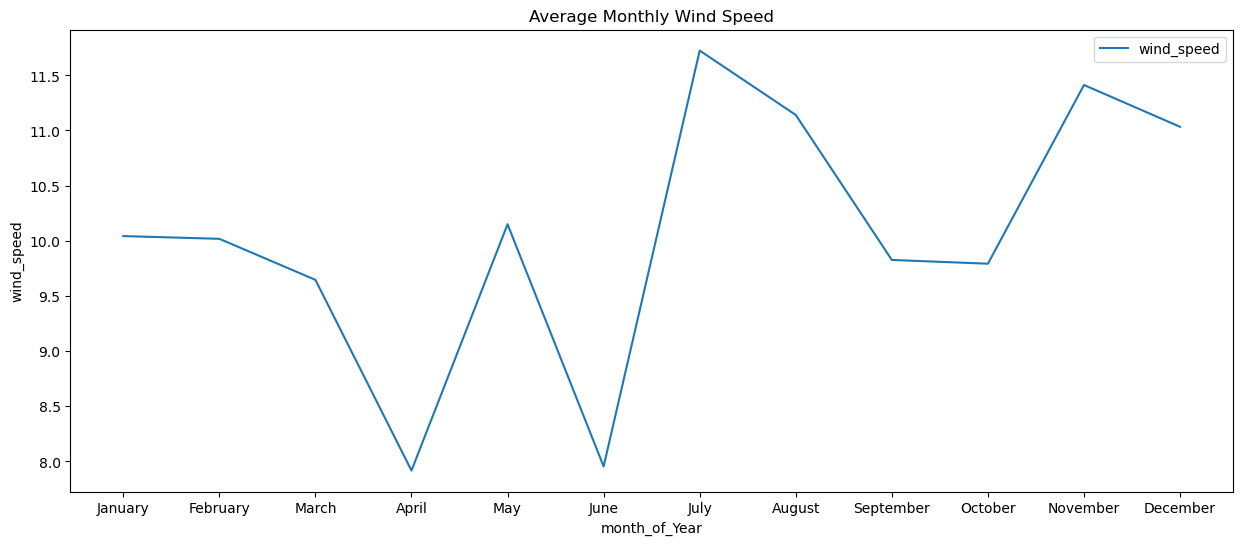

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df['month_of_Year'], y=df['wind_speed'], label='wind_speed', ci=None)
plt.title("Average Monthly Wind Speed")
plt.show()

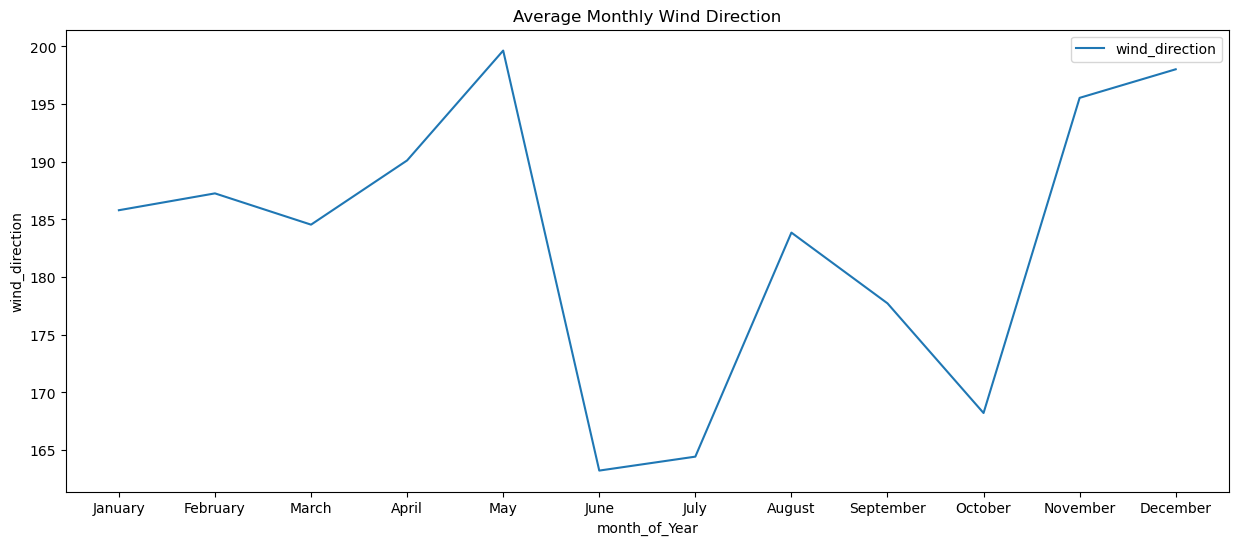

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df['month_of_Year'], y=df['wind_direction'], label='wind_direction', ci=None)
plt.title("Average Monthly Wind Direction")
plt.show()

In [ ]:
# Set timestamp as index column as this is a timeseries analysis

df = df.set_index('timestamp')
df

,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction,year,month,month_of_Year,day,day_of_Week,hour,is_weekend
timestamp,,,,,,,,,,,,,,
2018-01-01 00:15:00,3.600,16.0,15.9,13.6,86.0,5.4,134.0,2018,1,January,1,Monday,0,0
2018-01-01 00:30:00,3.846,16.0,15.9,13.7,87.0,5.4,115.0,2018,1,January,1,Monday,0,0
2018-01-01 00:45:00,4.099,16.2,15.8,13.6,87.0,3.6,120.0,2018,1,January,1,Monday,0,0
2018-01-01 01:00:00,3.951,16.7,15.6,13.4,87.0,0.0,120.0,2018,1,January,1,Monday,1,0
2018-01-01 01:15:00,3.958,16.4,15.4,13.2,87.0,0.0,120.0,2018,1,January,1,Monday,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:45:00,3.646,14.3,15.0,8.5,65.0,1.8,179.0,2019,12,December,31,Tuesday,22,0
2019-12-31 23:00:00,3.348,13.4,14.8,8.7,67.0,1.8,177.0,2019,12,December,31,Tuesday,23,0
2019-12-31 23:15:00,3.160,13.5,14.8,9.0,68.0,5.4,149.0,2019,12,December,31,Tuesday,23,0


In [ ]:
df.isnull().any()

consumption              False
apparent_temperature      True
air_temperature           True
dew_point_temperature     True
relative_humidity         True
wind_speed                True
wind_direction            True
year                     False
month                    False
month_of_Year            False
day                      False
day_of_Week              False
hour                     False
is_weekend               False
dtype: bool

In [ ]:
# Check for missing values

df.isnull().sum()

consumption                0
apparent_temperature     388
air_temperature          388
dew_point_temperature    388
relative_humidity        388
wind_speed               388
wind_direction           388
year                       0
month                      0
month_of_Year              0
day                        0
day_of_Week                0
hour                       0
is_weekend                 0
dtype: int64

In [ ]:
df[df['apparent_temperature'].isnull()]

,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction,year,month,month_of_Year,day,day_of_Week,hour,is_weekend
timestamp,,,,,,,,,,,,,,
2018-01-11 10:45:01,-0.673,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,January,11,Thursday,10,0
2018-01-26 21:15:04,-0.740,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,January,26,Friday,21,0
2018-01-27 20:15:25,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,January,27,Saturday,20,1
2018-01-27 21:30:45,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,January,27,Saturday,21,1
2018-01-27 21:45:05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,January,27,Saturday,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-21 22:46:21,0.030,NaN,NaN,NaN,NaN,NaN,NaN,2019,11,November,21,Thursday,22,0
2019-11-22 01:15:44,0.030,NaN,NaN,NaN,NaN,NaN,NaN,2019,11,November,22,Friday,1,0
2019-11-22 01:30:54,0.030,NaN,NaN,NaN,NaN,NaN,NaN,2019,11,November,22,Friday,1,0


In [ ]:
df = df.interpolate(method='ffill', )
df.isnull().any()

consumption              False
apparent_temperature     False
air_temperature          False
dew_point_temperature    False
relative_humidity        False
wind_speed               False
wind_direction           False
year                     False
month                    False
month_of_Year            False
day                      False
day_of_Week              False
hour                     False
is_weekend               False
dtype: bool

### Outlier Detection

<AxesSubplot:xlabel='consumption'>

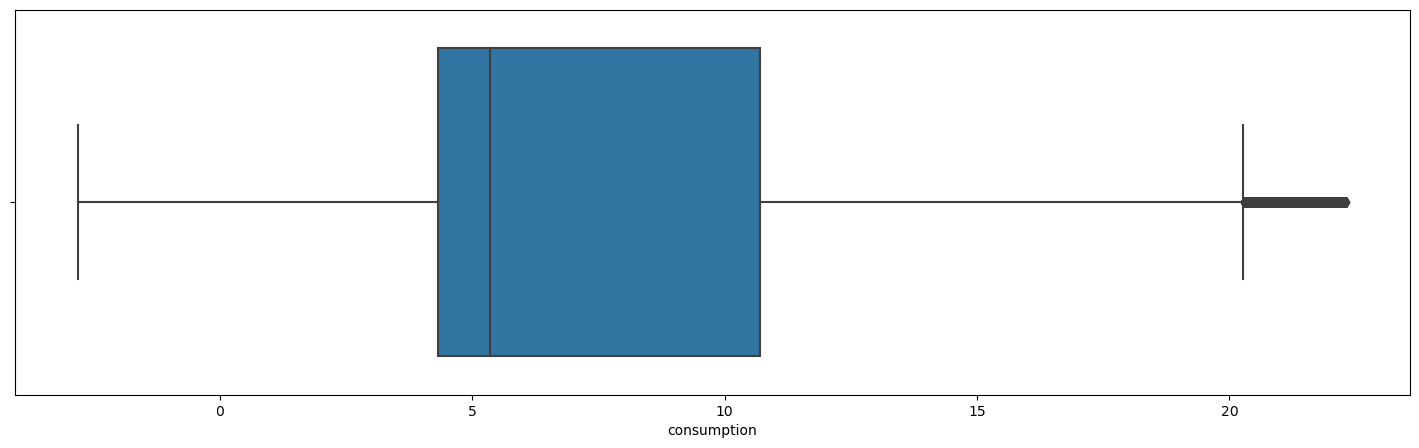

In [ ]:
sns.boxplot(df['consumption'])

<AxesSubplot:xlabel='apparent_temperature'>

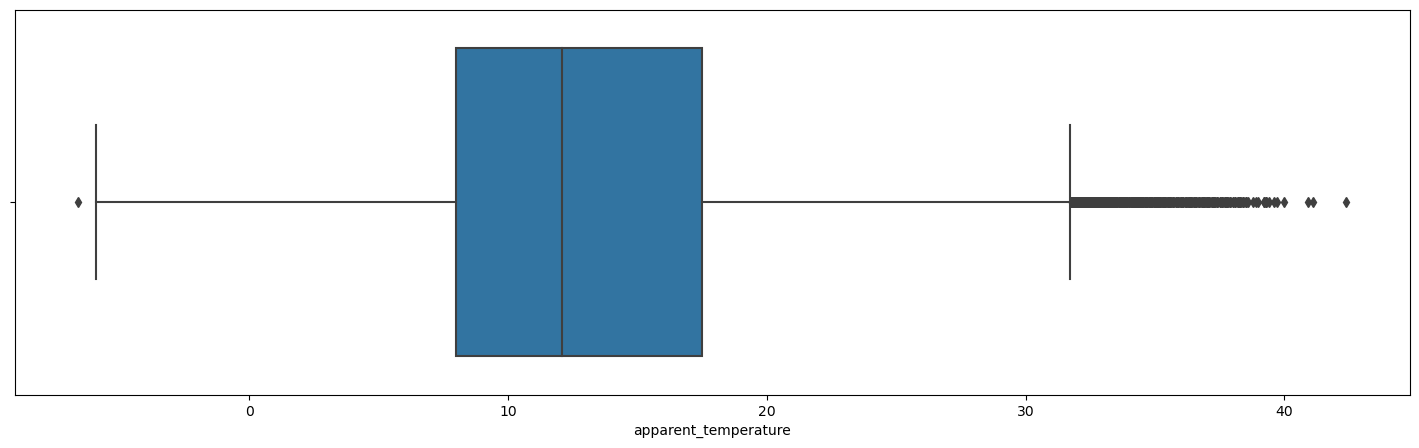

In [ ]:
sns.boxplot(df['apparent_temperature'])

<AxesSubplot:xlabel='air_temperature'>

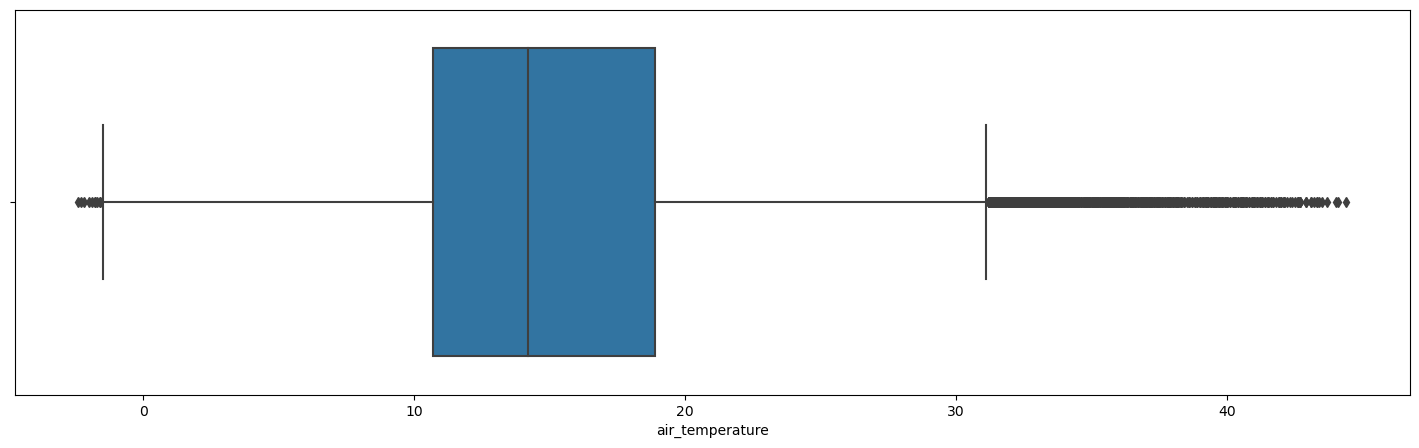

In [ ]:
sns.boxplot(df['air_temperature'])

<AxesSubplot:xlabel='dew_point_temperature'>

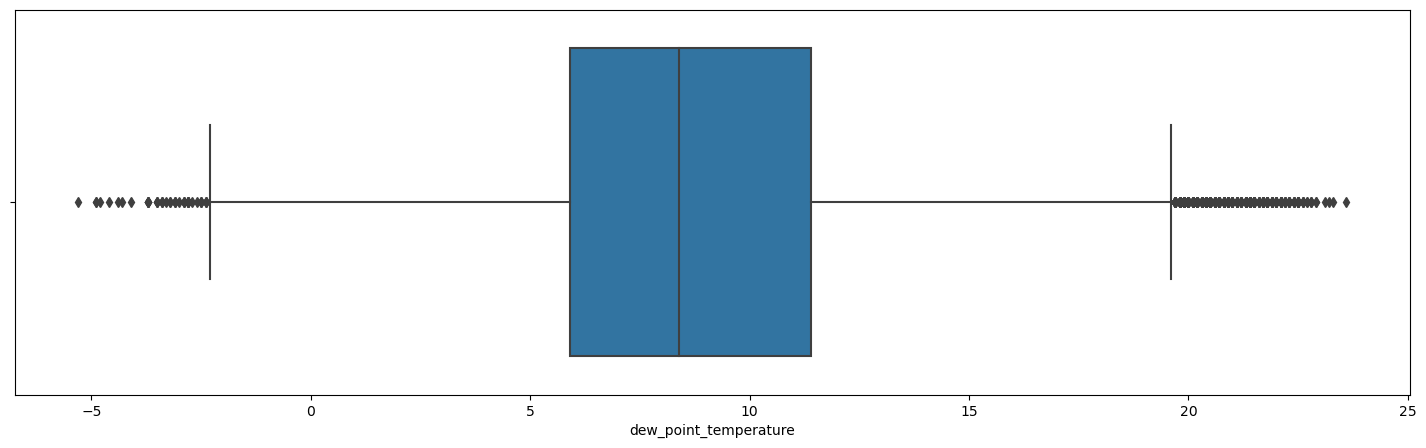

In [ ]:
sns.boxplot(df['dew_point_temperature'])

<AxesSubplot:xlabel='relative_humidity'>

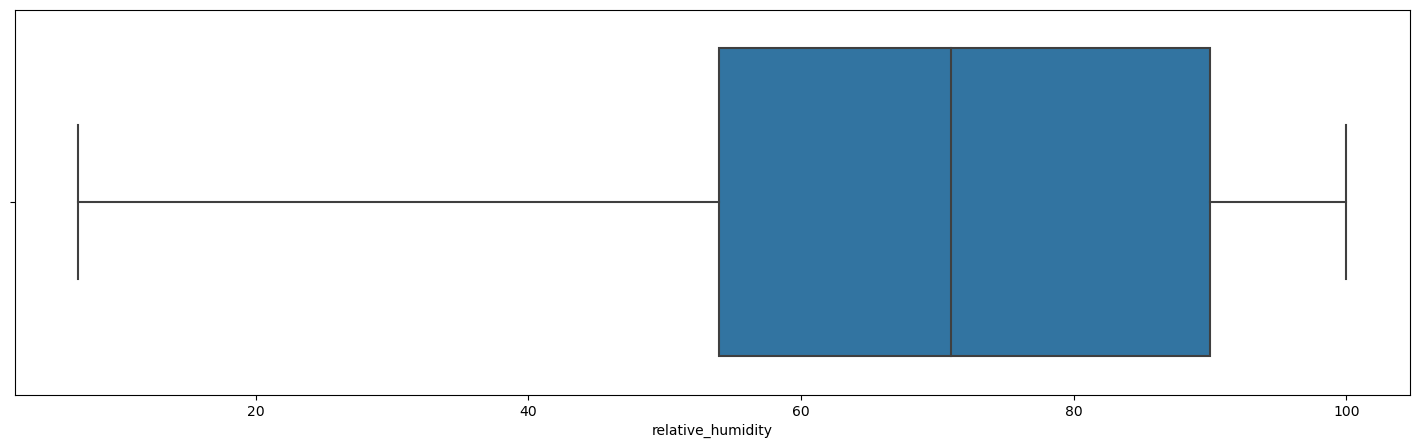

In [ ]:
sns.boxplot(df['relative_humidity'])

<AxesSubplot:xlabel='wind_speed'>

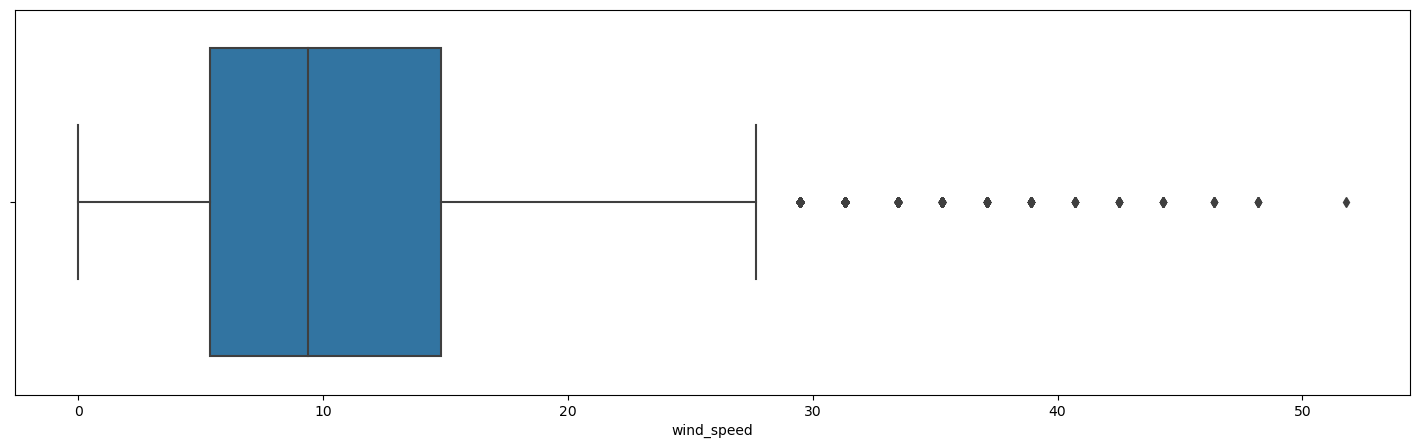

In [ ]:
sns.boxplot(df['wind_speed'])

<AxesSubplot:xlabel='wind_direction'>

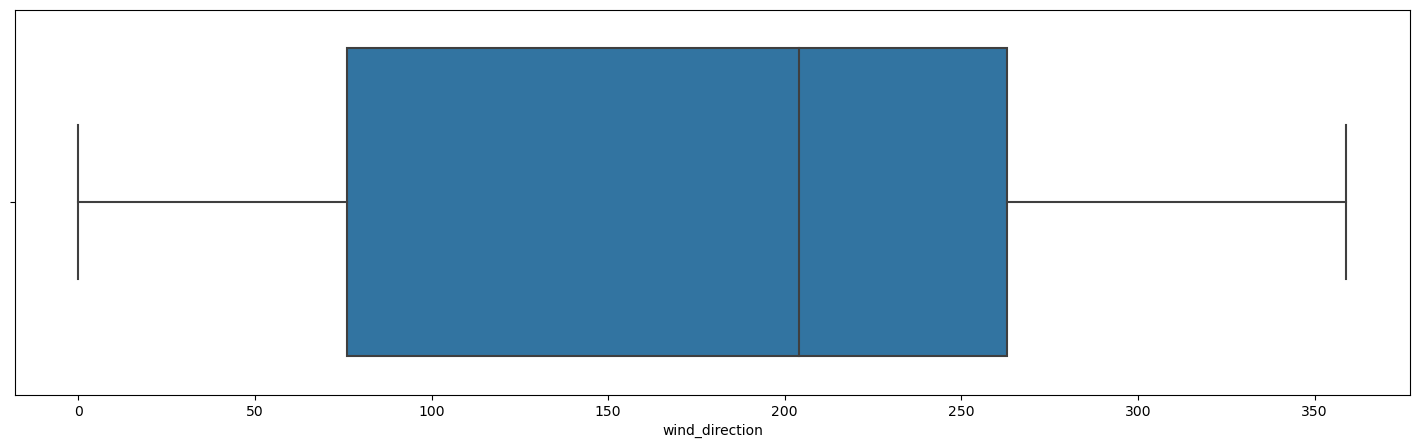

In [ ]:
sns.boxplot(df['wind_direction'])

# Inferential Statistical Analysis

### Correlation matrix

In [ ]:
# Drop non-numeric columns

df_corr = df.drop(columns=['year','month_of_Year','day_of_Week'])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'consumption'),
  Text(1.5, 0, 'apparent_temperature'),
  Text(2.5, 0, 'air_temperature'),
  Text(3.5, 0, 'dew_point_temperature'),
  Text(4.5, 0, 'relative_humidity'),
  Text(5.5, 0, 'wind_speed'),
  Text(6.5, 0, 'wind_direction'),
  Text(7.5, 0, 'month'),
  Text(8.5, 0, 'day'),
  Text(9.5, 0, 'hour'),
  Text(10.5, 0, 'is_weekend')])

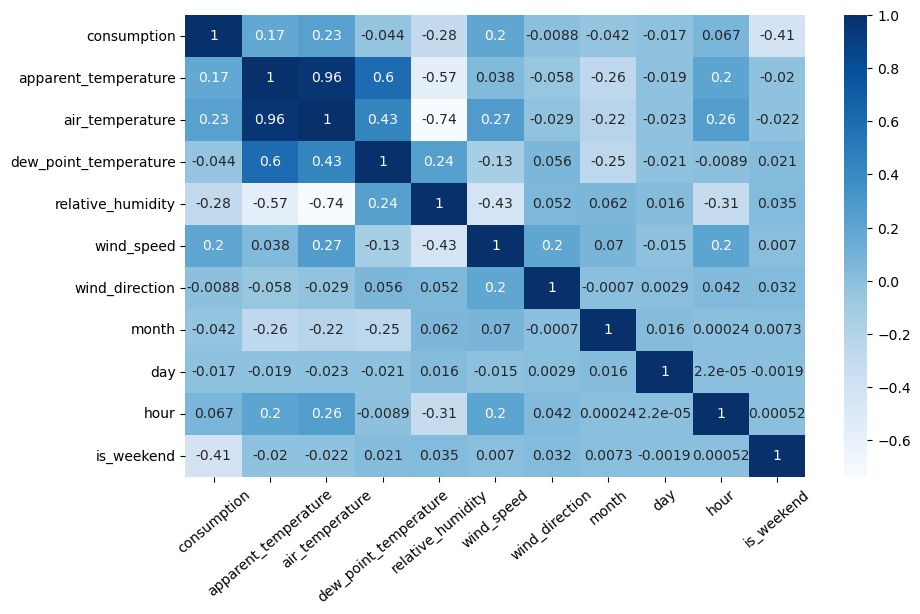

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(), annot=True, cmap='Blues')
plt.xticks(rotation=40)

- Multicollinearity exists between temperature feaures. Apparent temperature will not be used for modelling
- Temperature, humidity and speed have a week correlation with energy consumption.
- is_weekend is the most correlated feature to the target feature consumption

<AxesSubplot:xlabel='consumption', ylabel='air_temperature'>

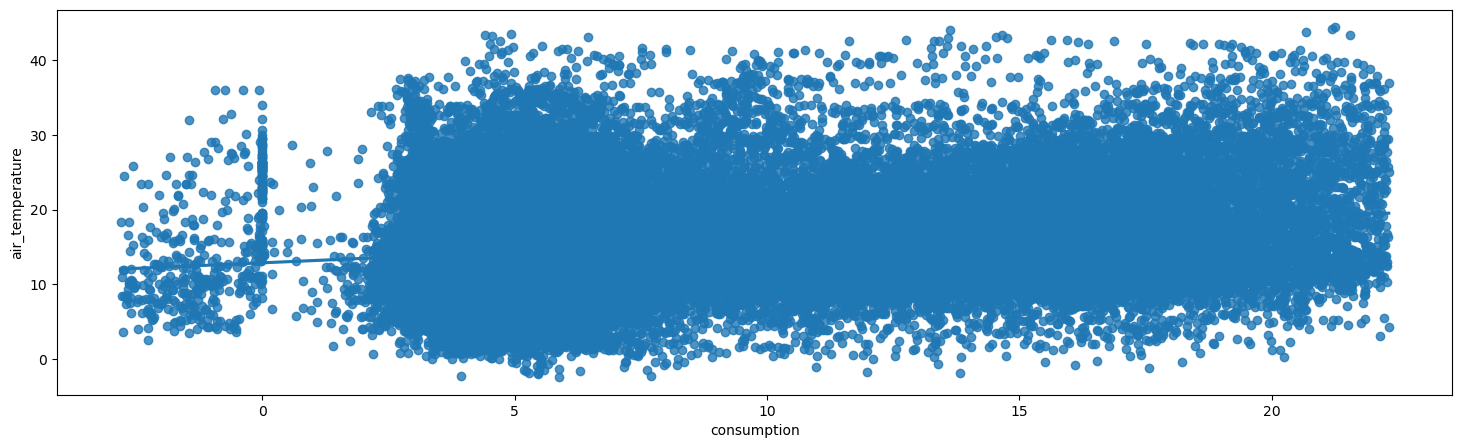

In [ ]:
sns.regplot(data=df, x='consumption', y='air_temperature')

In [ ]:
df_resample = df.resample('6H').agg({'consumption': np.sum, 'apparent_temperature': np.mean, 'air_temperature': np.mean, 'dew_point_temperature': np.mean, 'relative_humidity': np.mean, 'wind_speed': np.mean, 'wind_direction': np.mean, 'month': np.max, 'day': np.mean, 'hour': np.max, 'is_weekend': np.max})
df_resample

,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction,month,day,hour,is_weekend
timestamp,,,,,,,,,,,
2018-01-01 00:00:00,91.224,16.260870,15.143478,14.165217,94.043478,1.095652,101.521739,1,1.0,5,0
2018-01-01 06:00:00,70.377,17.562500,17.975000,12.291667,71.750000,5.933333,176.041667,1,1.0,11,0
2018-01-01 12:00:00,67.014,22.675000,24.816667,10.258333,40.083333,11.579167,192.166667,1,1.0,17,0
2018-01-01 18:00:00,78.752,17.445833,19.491667,12.816667,65.916667,15.087500,204.000000,1,1.0,23,0
2018-01-02 00:00:00,97.487,15.908333,16.750000,12.470833,76.041667,8.325000,178.166667,1,2.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 18:00:00,89.187,25.191667,27.150000,14.441667,56.916667,17.670833,212.541667,12,30.0,23,0
2019-12-31 00:00:00,85.601,16.604167,17.333333,16.129167,92.916667,14.450000,202.250000,12,31.0,5,0
2019-12-31 06:00:00,103.338,13.666667,16.041667,11.991667,78.958333,16.100000,219.416667,12,31.0,11,0


<AxesSubplot:xlabel='consumption', ylabel='air_temperature'>

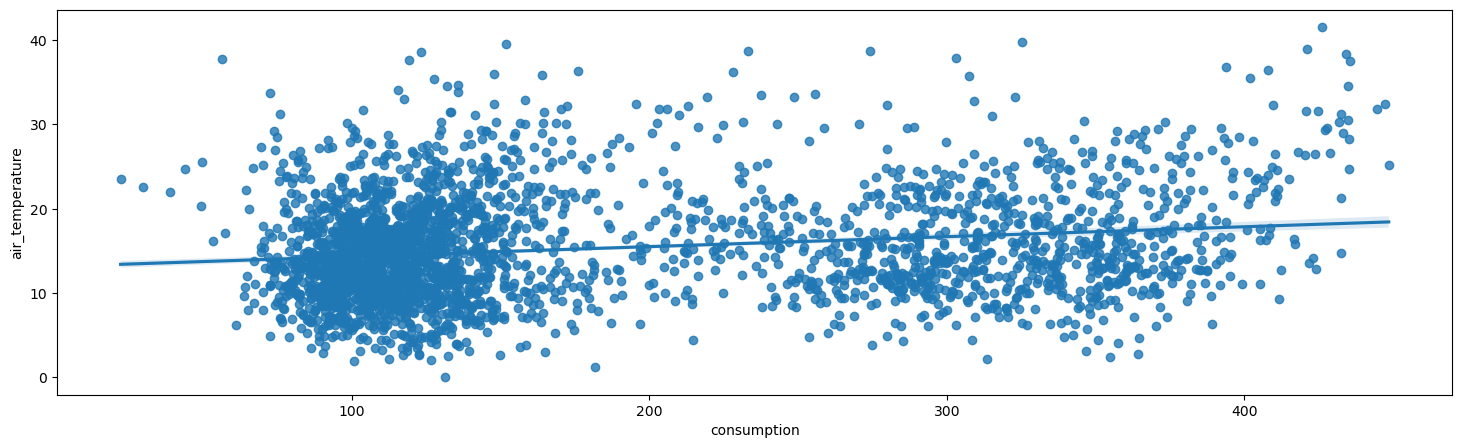

In [ ]:
sns.regplot(data=df_resample, x='consumption', y='air_temperature')

# Machine Learning Prediction

In [ ]:
# Extract target and independent features for prediction (X= independent features, y= target feature)

X = df[['air_temperature', 'relative_humidity', 'wind_speed', 'is_weekend']].values
y = df['consumption'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Define variables to store prediction models

names = ['LinearRegression', 'DecisionTreeRegressor', 'XGBRegressor', 'MLPRegressor']
classifiers = [LinearRegression(), tree.DecisionTreeRegressor(), xgb.XGBRegressor(), MLPRegressor()]

In [ ]:
# Create a list to store the results of the models

scores=[]
for name,clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    scores.append(score)

# Evaluate and compare model performance

df_model = pd.DataFrame()
df_model['Model'] = names
df_model['R2 Score'] = scores
df_model.sort_values(by="R2 Score", ascending=False)

,Model,R2 Score
2,XGBRegressor,0.314424
3,MLPRegressor,0.284065
0,LinearRegression,0.253537
1,DecisionTreeRegressor,-0.243424


- The models perform poorly and will require feature transformation on one or more independent features

### Feature transformation

In [ ]:
# Transform hour feature by binning into 6 parts of the day namely; 
# late night, early morning, morning, noon, evening and night represented in numbers [0,1,2,3,4,5]

b = [0,4,8,12,16,20,24]
l = [0,1,2,3,4,5]
df['time_of_day'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)

df

,consumption,apparent_temperature,air_temperature,dew_point_temperature,relative_humidity,wind_speed,wind_direction,year,month,month_of_Year,day,day_of_Week,hour,is_weekend,time_of_day
timestamp,,,,,,,,,,,,,,,
2018-01-01 00:15:00,3.600,16.0,15.9,13.6,86.0,5.4,134.0,2018,1,January,1,Monday,0,0,0
2018-01-01 00:30:00,3.846,16.0,15.9,13.7,87.0,5.4,115.0,2018,1,January,1,Monday,0,0,0
2018-01-01 00:45:00,4.099,16.2,15.8,13.6,87.0,3.6,120.0,2018,1,January,1,Monday,0,0,0
2018-01-01 01:00:00,3.951,16.7,15.6,13.4,87.0,0.0,120.0,2018,1,January,1,Monday,1,0,0
2018-01-01 01:15:00,3.958,16.4,15.4,13.2,87.0,0.0,120.0,2018,1,January,1,Monday,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 22:45:00,3.646,14.3,15.0,8.5,65.0,1.8,179.0,2019,12,December,31,Tuesday,22,0,5
2019-12-31 23:00:00,3.348,13.4,14.8,8.7,67.0,1.8,177.0,2019,12,December,31,Tuesday,23,0,5
2019-12-31 23:15:00,3.160,13.5,14.8,9.0,68.0,5.4,149.0,2019,12,December,31,Tuesday,23,0,5


In [ ]:
# Repeat train test process including transformed feature 'time_of_day'

X = df[['air_temperature', 'relative_humidity', 'wind_speed', 'is_weekend', 'time_of_day']].values
y = df['consumption'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Machine Learning Model Evaluation 

In [ ]:
# Create a list to store the results of the models

scores=[]
for name,clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    scores.append(score)

# Evaluate and compare model performance

df_model = pd.DataFrame()
df_model['Model'] = names
df_model['R2 Score'] = scores
df_model.sort_values(by="R2 Score", ascending=False)

,Model,R2 Score
2,XGBRegressor,0.713162
3,MLPRegressor,0.684113
1,DecisionTreeRegressor,0.479382
0,LinearRegression,0.254998


- R2 score improved accross models with XGB having the highest score

In [ ]:
# Create a list to store the results of the models

mse=[]
for name,clf in zip(names,classifiers):
#     clf.fit(X_train, y_train)
    y_mse_predict = clf.predict(X_test)
    error=metrics.mean_squared_error(y_test, y_mse_predict, squared=False)
    mse.append(error)

    
# Evaluate and compare model performance
df_model = pd.DataFrame()
df_model['Model'] = names
df_model['Mean Squared Error'] = mse
df_model.sort_values(by="Mean Squared Error")

,Model,Mean Squared Error
2,XGBRegressor,2.677395
3,MLPRegressor,2.809702
1,DecisionTreeRegressor,3.607064
0,LinearRegression,4.314921


Text(0, 0.5, 'Predicted')

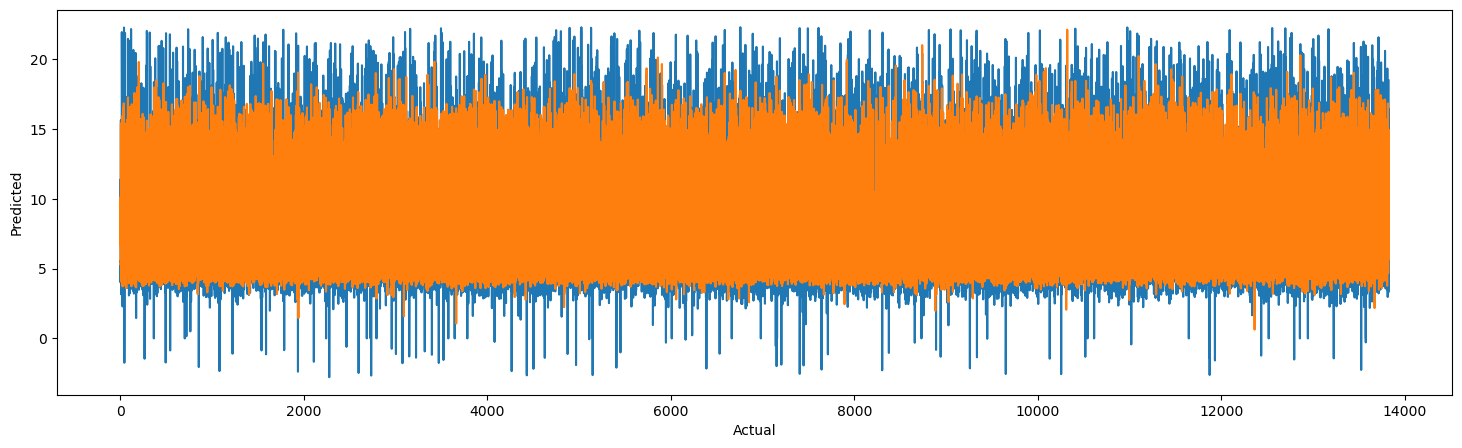

In [ ]:
# Graph of predicted vs Actual test data
# From the graph, we can see that the predicted values in orange colors are relatively close to the actual values in blue

# Visualise actual vs predicted on a scatter plot 

XGB = xgb.XGBRegressor() # notice here we use the Regressor while for classification we used XGBClassifier
XGB.fit(X_train,y_train)
y_predict = XGB.predict(X_test)

# plt.figure(figsize = (50,30))
plt.plot(y_test, label='Actual')
plt.plot(y_predict, label='Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Deep Learning

In [ ]:
# Resample energy dataset to 12 hour interval for deep learning prediction

df_consumption2 = df_consumption[df_consumption['timestamp'].dt.year.between(2018,2019, inclusive=True)]

df_consumption2 = df_consumption2.set_index('timestamp')
df_consumption2 = df_consumption2.resample('12H').mean()
df_consumption2

,consumption
timestamp,
2018-01-01 00:00:00,3.438319
2018-01-01 12:00:00,3.036792
2018-01-02 00:00:00,5.451917
2018-01-02 12:00:00,5.770875
2018-01-03 00:00:00,6.434812
...,...
2019-12-29 12:00:00,3.259417
2019-12-30 00:00:00,6.065458
2019-12-30 12:00:00,7.567875


In [ ]:
# Check for Null values

df_consumption2.isnull().sum()

consumption    0
dtype: int64

<AxesSubplot:xlabel='timestamp'>

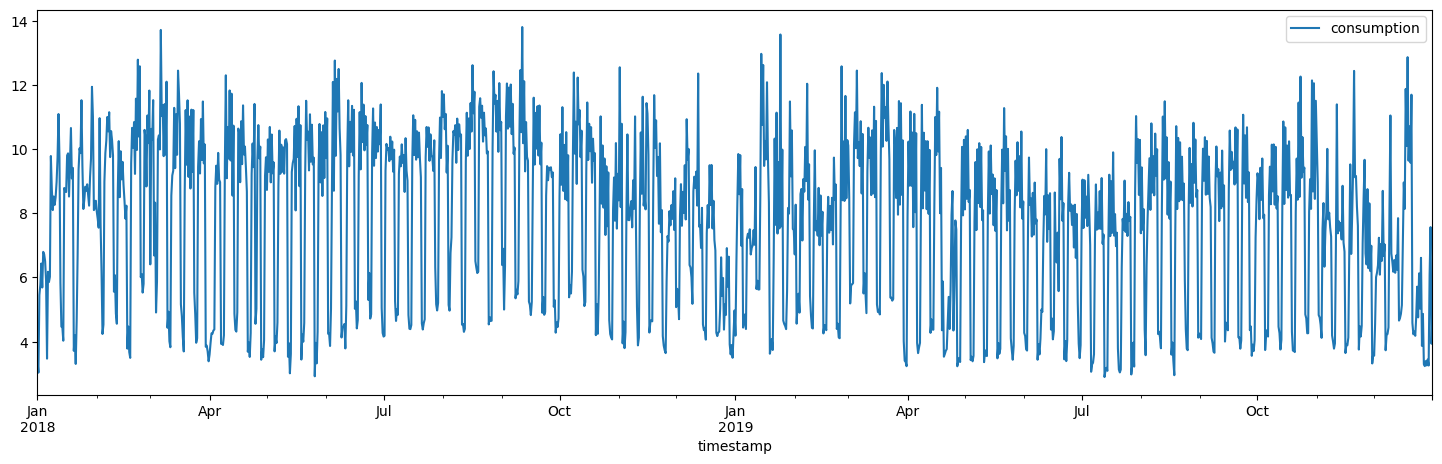

In [ ]:
# Graphical representation of 12 hour interval energy consumption for the period 2018 - 2019

df_consumption2.plot()

### Test for Stationarity

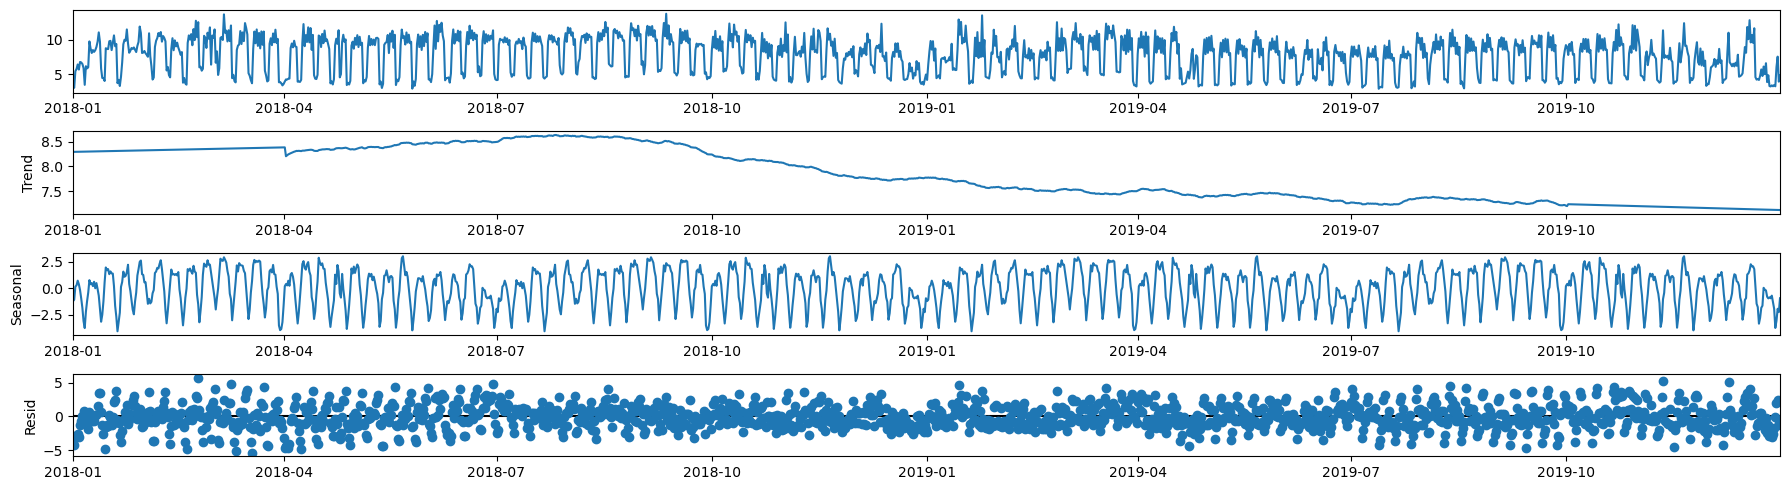

In [ ]:
# plt.figure(figsize=(10, 5))

result = seasonal_decompose(df_consumption2, extrapolate_trend='freq', period=365)
# result = seasonal_decompose(df_consumption2)
result.plot()
plt.show()

- Visual representation of time series trend, seasonality and residual
- The data seems to be fairly stationary
- We will further justify this by Dickey Fuller test: 
- Null hypothesis - In order to reject the null hypothesis; P-value must be less than 5%, hence, which implies that the data series is stationary
- Reject null hypothesis if p-value is less than 5% (0.05)

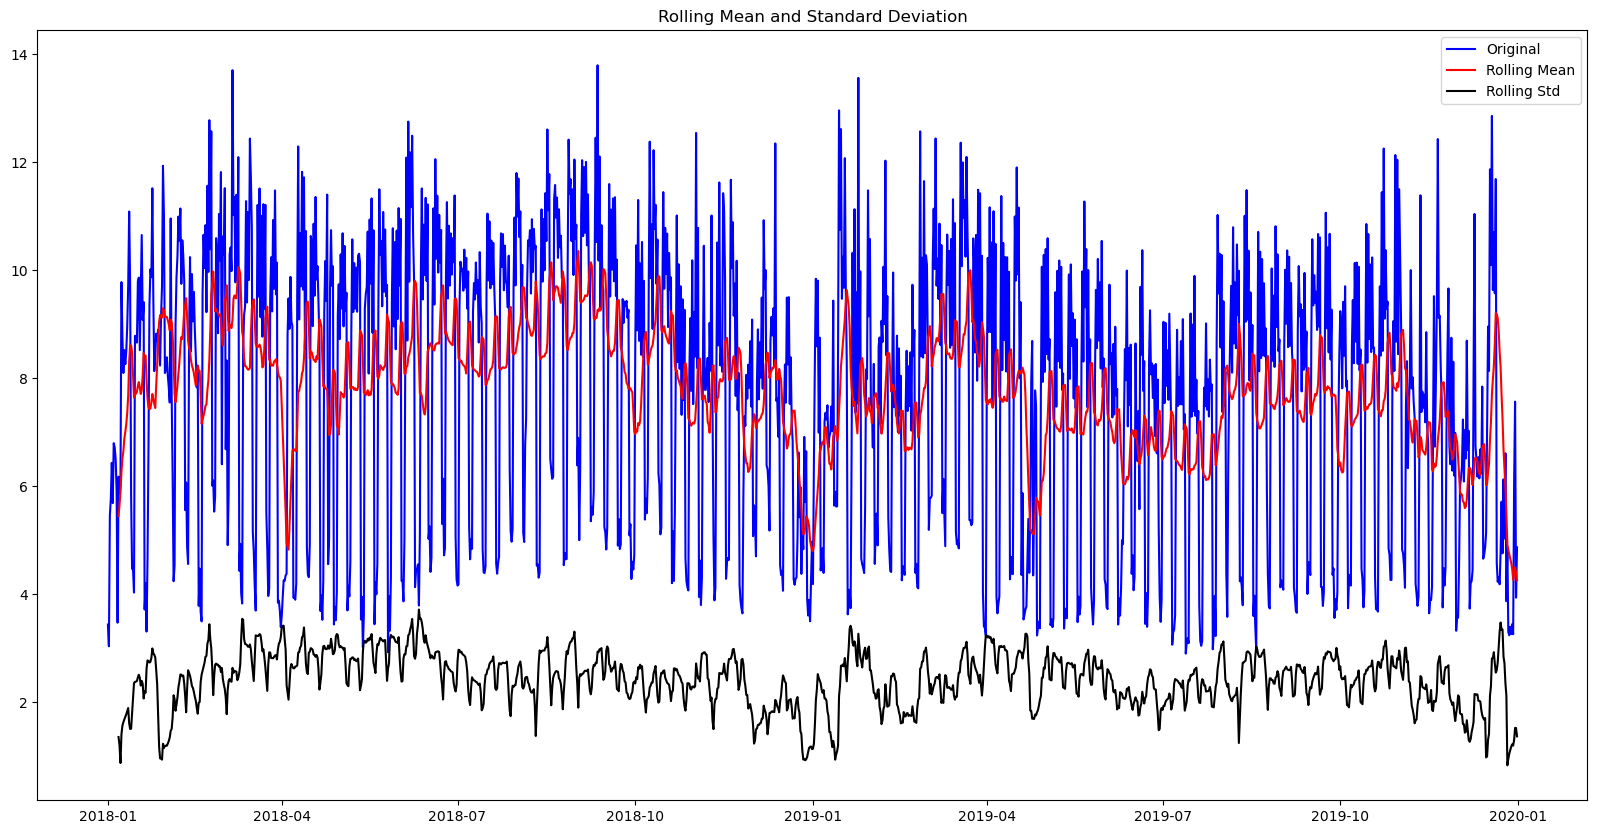

Results of dickey fuller test
Test Statistics                  -4.305287
p-value                           0.000435
No. of lags used                 24.000000
Number of observations used    1435.000000
critical value (1%)              -3.434915
critical value (5%)              -2.863556
critical value (10%)             -2.567843
dtype: float64


In [ ]:
# Dickey Fuller Test:

# from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_consumption2)

 - P-value is less than 0.05. Reject null hypothesis

# Recurrent neural network - LSTM

In [ ]:
len(df_consumption2)

1460

In [ ]:
# Split train/test data: Predict the last 2 weeks (14 days) which represents 28 data points

test_size = 28

train = df_consumption2[:-test_size]
test = df_consumption2[-test_size:]

In [ ]:
df_consumption2.head(), df_consumption2.tail()

(                     consumption
 timestamp                       
 2018-01-01 00:00:00     3.438319
 2018-01-01 12:00:00     3.036792
 2018-01-02 00:00:00     5.451917
 2018-01-02 12:00:00     5.770875
 2018-01-03 00:00:00     6.434812,
                      consumption
 timestamp                       
 2019-12-29 12:00:00     3.259417
 2019-12-30 00:00:00     6.065458
 2019-12-30 12:00:00     7.567875
 2019-12-31 00:00:00     3.936229
 2019-12-31 12:00:00     4.868833)

In [ ]:
# Normalize train and test datasets

scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

array([[0.04933458],
       [0.01248844],
       [0.23411218],
       ...,
       [0.55595085],
       [0.48043598],
       [0.82308808]])

In [ ]:
# define timeseriesgenerator

n_input = 28
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=1)

In [ ]:
len(scaled_train), len(generator)

(1432, 1404)

In [ ]:
# Flatten data

X,y = generator[0]
print(f'Actual consumption: \t {X.flatten()}')
print(f'Predicted: \t {y}')

Actual consumption: 	 [0.04933458 0.01248844 0.23411218 0.26338136 0.32430753 0.25578973
 0.35765643 0.35071671 0.33091785 0.2756836  0.05251897 0.30070292
 0.27137829 0.28626906 0.63143514 0.53733787 0.47696994 0.51578841
 0.49200218 0.51395311 0.55717353 0.62703807 0.75139674 0.62736499
 0.26915491 0.14402197 0.14300874 0.1037735 ]
Predicted: 	 [[0.54008699]]


In [ ]:
X.shape

(1, 28, 1)

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

In [ ]:
# LSTM Model definition

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model using 50 epochs

model.fit(generator,epochs=50)

Epoch 1/50
1404/1404 [==============================] - 17s 11ms/step - loss: 0.0445
Epoch 2/50
1404/1404 [==============================] - 14s 10ms/step - loss: 0.0270
Epoch 3/50
1404/1404 [==============================] - 15s 10ms/step - loss: 0.0233
Epoch 4/50
1404/1404 [==============================] - 15s 11ms/step - loss: 0.0219
Epoch 5/50
1404/1404 [==============================] - 16s 11ms/step - loss: 0.0203
Epoch 6/50
1404/1404 [==============================] - 15s 10ms/step - loss: 0.0194
Epoch 7/50
1404/1404 [==============================] - 16s 12ms/step - loss: 0.0179
Epoch 8/50
1404/1404 [==============================] - 19s 13ms/step - loss: 0.0159
Epoch 9/50
1404/1404 [==============================] - 19s 13ms/step - loss: 0.0151
Epoch 10/50
1404/1404 [==============================] - 18s 13ms/step - loss: 0.0143
Epoch 11/50
1404/1404 [==============================] - 19s 13ms/step - loss: 0.0140
Epoch 12/50
1404/1404 [==============================] - 20s 14

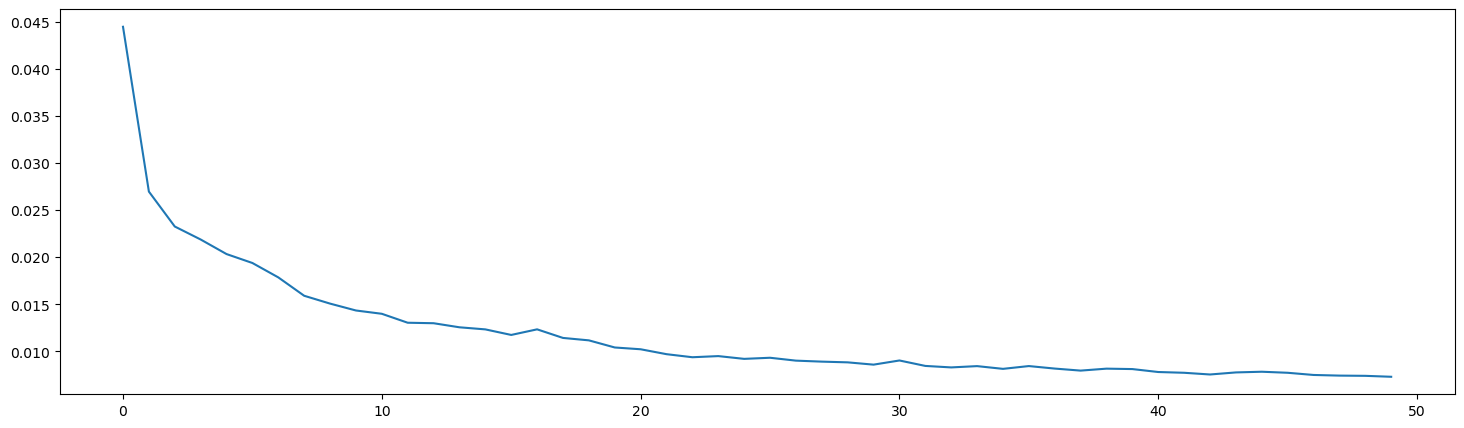

In [ ]:
# Plot epoch loss graph

epoch_loss = model.history.history['loss']
plt.plot(range(len(epoch_loss)), epoch_loss)

- From the graph below, the loss is steady from 30 which means we could have also used 30 as the epoch loss value.

In [ ]:
# test

last_train_batch = scaled_train[-28:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 361ms/step


array([[0.48329675]], dtype=float32)

In [ ]:
# scaled_test[0]

In [ ]:
test_predictions_scaled = []                                        # Create an empty list of predictions

eval_1 = scaled_train[-n_input:]                                    # last 28 values in the predictions
cur_batch = eval_1.reshape((1, n_input, n_features))                # Reshape  predictions with temeseries generator parameters

for i in range(len(test)):                                          #
    cur_pred = model.predict(cur_batch)[0]                          # 1st batch prediction value
    test_predictions_scaled.append(cur_pred)                        # Append result to previously created array
    cur_batch = np.append(cur_batch[:,1:,:], [[cur_pred]], axis=1)  # Update the prediction batch

1/1 [==============================] - 0s 31ms/step


In [ ]:
# Predicted energy consumption in normalized form

test_predictions_scaled

[array([0.48329675], dtype=float32),
 array([0.6245387], dtype=float32),
 array([0.4807256], dtype=float32),
 array([0.6128449], dtype=float32),
 array([0.47731668], dtype=float32),
 array([0.5058124], dtype=float32),
 array([0.39050108], dtype=float32),
 array([0.3535313], dtype=float32),
 array([0.324349], dtype=float32),
 array([0.3183975], dtype=float32),
 array([0.42007238], dtype=float32),
 array([0.53721005], dtype=float32),
 array([0.5262248], dtype=float32),
 array([0.52595246], dtype=float32),
 array([0.5060392], dtype=float32),
 array([0.53691894], dtype=float32),
 array([0.528939], dtype=float32),
 array([0.5197161], dtype=float32),
 array([0.5219503], dtype=float32),
 array([0.49798107], dtype=float32),
 array([0.41114473], dtype=float32),
 array([0.38881272], dtype=float32),
 array([0.38790065], dtype=float32),
 array([0.40913147], dtype=float32),
 array([0.5342486], dtype=float32),
 array([0.5989636], dtype=float32),
 array([0.4416256], dtype=float32),
 array([0.52321094

In [ ]:
# Predicted energy consumption in original scale

test_predictions = scaler.inverse_transform(test_predictions_scaled)
test_predictions

array([[8.16738339],
       [9.70655518],
       [8.13936435],
       [9.57912265],
       [8.10221607],
       [8.41274574],
       [7.15615083],
       [6.75327593],
       [6.43526425],
       [6.37040837],
       [7.47840139],
       [8.75489874],
       [8.6351879 ],
       [8.63222016],
       [8.41521722],
       [8.7517264 ],
       [8.66476583],
       [8.56425983],
       [8.58860705],
       [8.32740446],
       [7.38111319],
       [7.13775206],
       [7.12781286],
       [7.3591738 ],
       [8.72262653],
       [9.42785279],
       [7.71327567],
       [8.60234474]])

### LSTM Model Evaluation

Text(0.5, 1.0, 'Energy consumption prediction')

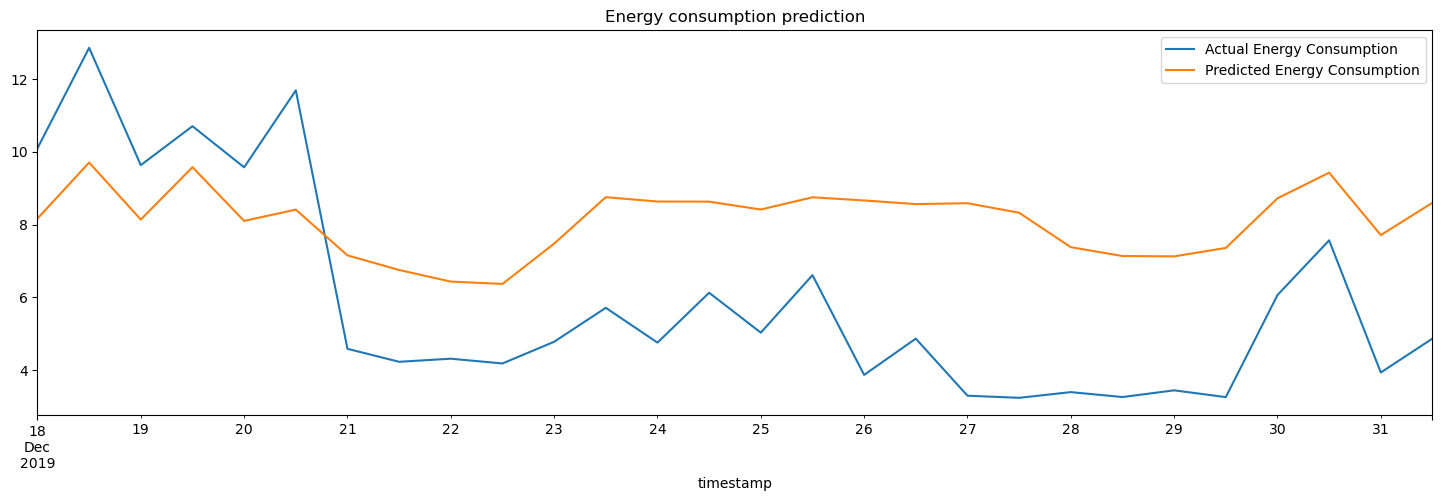

In [ ]:
# Actual vs Predicted consumption

test['consumption_prediction'] = test_predictions

test.plot()
plt.legend(['Actual Energy Consumption', 'Predicted Energy Consumption'])
plt.title('Energy consumption prediction')

In [ ]:
# rmse = sqrt(mean_squared_error(test['consumption'], test['consumption_prediction']))
mse_lstm = mean_squared_error(test['consumption'], test['consumption_prediction'])
mse_lstm

10.596386334578352

- The 2 weeks predicted energy consumption is fairly close to the oactual energy consumption with 8.06 MSE.
- Due to will perform  better if we have more historic data to train on. Deep learning performs better on large volume of datasets.